In [26]:
from explainers.gnninterpreter import * 


In [27]:
import torch
from torch import nn
import libraries.dataLoaderWrapper

In [28]:
dataset = torch.load('model/test_loader_red_ratio.pt')


In [29]:

# dataset[1310]


In [30]:
len(dataset)

8000

In [31]:
model = GCNClassifier(node_features=3,
                      num_classes=2,
                      hidden_channels=32)

model.load_state_dict(torch.load('model/model_red_class.pt'))

<All keys matched successfully>

In [32]:
def mean_embeddingsf(dataloader, model, batch_size=32):
    embeds = [[] for _ in range(2)]
    model.eval()
    for batch in dataloader:
        for i, e in enumerate(model(batch)['embeds']):
            embeds[batch.y[i].item()].append(e)
    return [torch.stack(e, dim=0).mean(axis=0) for e in embeds]

In [33]:
mean_embeds = dataset.mean_embeddings(model)

In [34]:
trainer = {}
sampler ={}

In [35]:
cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=3,
        temperature=0.15,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [36]:
trainer[1].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

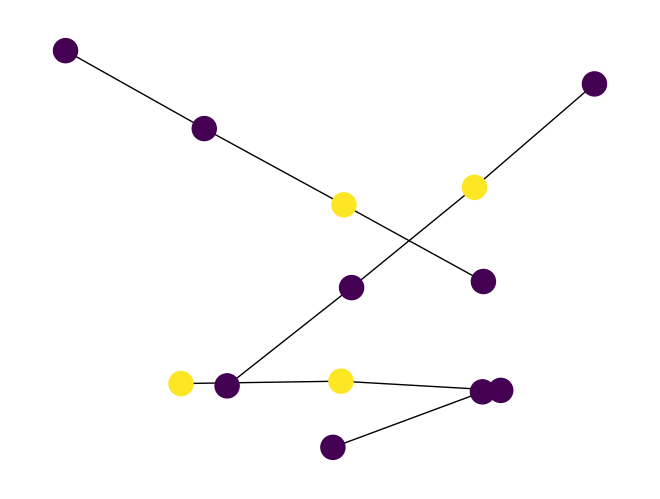

In [41]:
graph = trainer[1].evaluate(threshold=0.5, show=False)
labels = [graph.nodes[node]['label'] for node in graph.nodes]
import networkx as nx
nx.draw(graph, nx.kamada_kawai_layout(graph), node_color=labels)

In [43]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=3,
        temperature=0.15,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [44]:
trainer[0].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

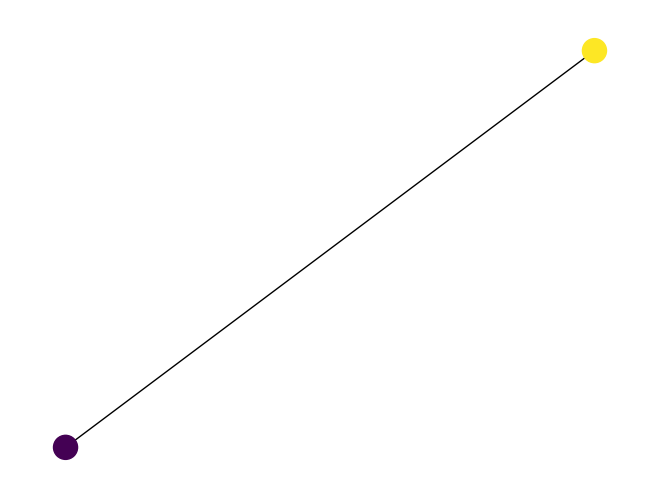

In [46]:
graph2 = trainer[0].evaluate(threshold=0.5, show=False)
labels = [graph2.nodes[node]['label'] for node in graph2.nodes]
import networkx as nx
nx.draw(graph2, nx.kamada_kawai_layout(graph2), node_color=labels)

In [ ]:
len(graph)

8